<a href="https://colab.research.google.com/github/Chuckboliver/Image-Processing/blob/main/6%20-%20Hyperparameter%20Tuning/Image_Processing_Lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing Lab06

## Import

In [ ]:
import glob
import tensorflow as tf
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Input
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 6.1 Data Preparation

In [ ]:
filenames = glob.glob("/content/drive/MyDrive/face_data/*/*.jpg")
len(filenames)

3203

In [ ]:
# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
n = 700
all_images = []
for img_path in filenames[:n]:
    img = image.load_img(img_path, target_size=(90, 90), interpolation="nearest")
    # convert the image to an array
    img = image.img_to_array(img)
    # Normalized color imageimg
    img = img/255
    all_images.append(img)

all_images = np.array(all_images)
all_images.shape

(700, 90, 90, 3)

### train-test-split

In [ ]:
# split data into train and validation data
train_x, test_x = train_test_split(all_images, test_size=0.3, random_state=32)
train_x, val_x = train_test_split(train_x, test_size=0.3, random_state=32)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(343, 90, 90, 3)
(147, 90, 90, 3)
(210, 90, 90, 3)


### Add noise

In [ ]:
noise_factor = 0.3
Nmean = 0
Nstd = 1

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))
x_val_noisy = val_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))
x_test_noisy = test_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))
print(x_train_noisy.shape)
print(x_val_noisy.shape)
print(x_test_noisy.shape)

(343, 90, 90, 3)
(147, 90, 90, 3)
(210, 90, 90, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


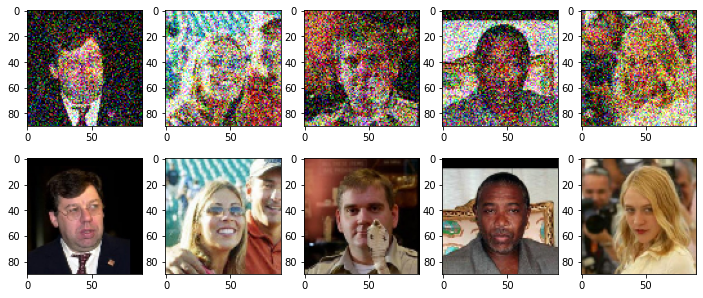

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5,  figsize=(12, 5))

ax[0, 0].imshow(x_train_noisy[1])
ax[1, 0].imshow(train_x[1])

ax[0, 1].imshow(x_train_noisy[2])
ax[1, 1].imshow(train_x[2])

ax[0, 2].imshow(x_train_noisy[3])
ax[1, 2].imshow(train_x[3])

ax[0, 3].imshow(x_train_noisy[4])
ax[1, 3].imshow(train_x[4])

ax[0, 4].imshow(x_train_noisy[5])
ax[1, 4].imshow(train_x[5])
plt.show()

## 6.2 Create Model
(Autoencoder )

In [ ]:
def create_model(optimizer="adam"):
  input_img = Input(shape=(90, 90, 3))

  # encoder layer
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D( (2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

  # decoding architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
  decoded = Conv2D(3, (3, 3), padding='same')(x1)

   # construct the autoencoder model
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
  return autoencoder

# ประกําศ KERAS ตัวจัดกํารพํารํามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)

## 6.3 Hyperparameter Tuning
( GridSearchCV() , RandomizedSearchCV() )

In [ ]:
# กำหนด Grid Search parameters
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

In [ ]:
grid = GridSearchCV( estimator=model,
                    verbose=1,
                    cv=2,
                    param_grid=param_grid)

In [ ]:
grid_result = grid.fit(x_train_noisy, train_x)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [ ]:
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
Best score:  -0.006621265318244696


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print(params)

[{'batch_size': 8, 'epochs': 2, 'optimizer': 'SGD'}, {'batch_size': 8, 'epochs': 2, 'optimizer': 'RMSprop'}, {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adadelta'}, {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adam'}, {'batch_size': 8, 'epochs': 4, 'optimizer': 'SGD'}, {'batch_size': 8, 'epochs': 4, 'optimizer': 'RMSprop'}, {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adadelta'}, {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adam'}, {'batch_size': 8, 'epochs': 6, 'optimizer': 'SGD'}, {'batch_size': 8, 'epochs': 6, 'optimizer': 'RMSprop'}, {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adadelta'}, {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}, {'batch_size': 16, 'epochs': 2, 'optimizer': 'SGD'}, {'batch_size': 16, 'epochs': 2, 'optimizer': 'RMSprop'}, {'batch_size': 16, 'epochs': 2, 'optimizer': 'Adadelta'}, {'batch_size': 16, 'epochs': 2, 'optimizer': 'Adam'}, {'batch_size': 16, 'epochs': 4, 'optimizer': 'SGD'}, {'batch_size': 16, 'epochs': 4, 'optimizer': 'RMSprop'}, {'batch_size'

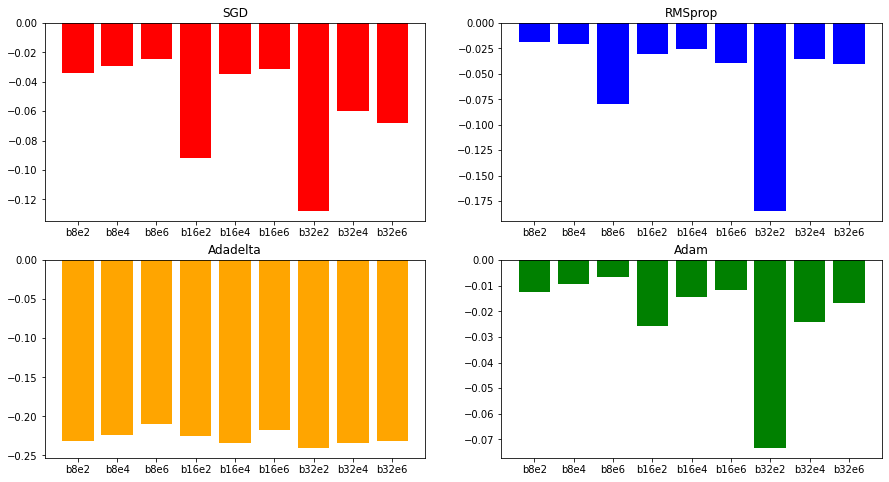

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# SGD
for p, m in zip(params, means):
  if p['optimizer'] == 'SGD':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[0, 0].bar(name, m, color="red")
    ax[0, 0].set_title("SGD")

# RMSProp
for p, m in zip(params, means):
  if p['optimizer'] == 'RMSprop':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[0, 1].bar(name, m, color="blue")
    ax[0, 1].set_title("RMSprop")

# Adadelta
for p, m in zip(params, means):
  if p['optimizer'] == 'Adadelta':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[1, 0].bar(name, m, color="orange")
    ax[1, 0].set_title("Adadelta")

# Adam
for p, m in zip(params, means):
  if p['optimizer'] == 'Adam':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[1, 1].bar(name, m, color="green")
    ax[1, 1].set_title("Adam")
plt.show()

In [ ]:
 #กำหนด Grid Search parameters
random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
'epochs': list(np.linspace(1, 10, 4, dtype = int))}

In [ ]:
grid_rand = RandomizedSearchCV( estimator=model,
                                verbose=1,
                                cv=2,
                                random_state = 10,
                                n_iter = 10,
                                param_distributions=random_search)

In [ ]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [ ]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'optimizer': 'RMSprop', 'epochs': 7, 'batch_size': 36}
Best score:  -0.019617578946053982


In [ ]:
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']

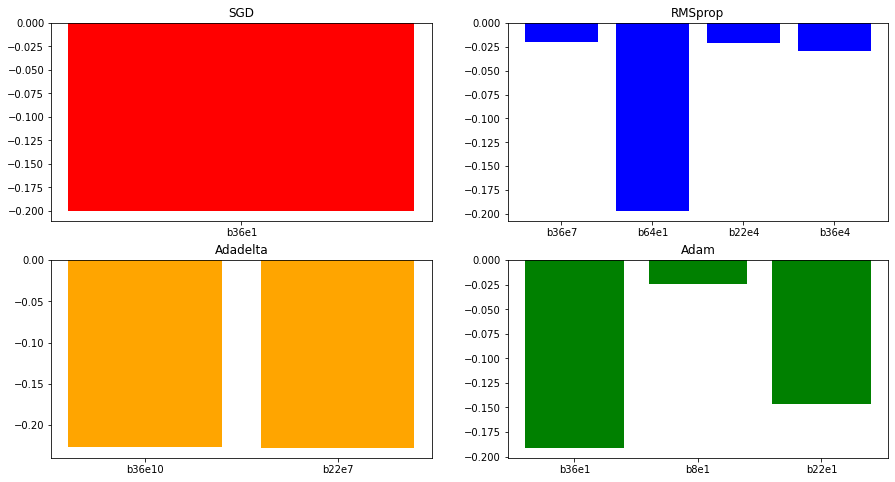

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# SGD
for p, m in zip(params, means):
  if p['optimizer'] == 'SGD':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[0, 0].bar(name, m, color="red")
    ax[0, 0].set_title("SGD")

# RMSProp
for p, m in zip(params, means):
  if p['optimizer'] == 'RMSprop':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[0, 1].bar(name, m, color="blue")
    ax[0, 1].set_title("RMSprop")

# Adadelta
for p, m in zip(params, means):
  if p['optimizer'] == 'Adadelta':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[1, 0].bar(name, m, color="orange")
    ax[1, 0].set_title("Adadelta")

# Adam
for p, m in zip(params, means):
  if p['optimizer'] == 'Adam':
    b = "b" + str(p['batch_size'])
    e = "e" + str(p['epochs'])
    name = b + e
    ax[1, 1].bar(name, m, color="green")
    ax[1, 1].set_title("Adam")
plt.show()